In [1]:
%matplotlib inline
import pandas as pd #pandas is a useful array/matrix/spreadsheet maipulator. But it has some unique language
import numpy as np #math stuff!
import matplotlib.pyplot as plt #plotting package.
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from sklearn.ensemble import RandomForestClassifier
from scipy import sparse
import scipy

In [2]:
#Importing the previously cleaned data. Only numbers to be found here!
Train=pd.read_csv('trainNum.csv', header=0)

In [3]:
Train.head(2)

,Outcome,Weekday,Address3_2,Address2_2,Year,Month,Day,Hour,Minute,X_binned,Y_binned
0,7,1,100,100,2015,5,13,23,53,6,6.0
1,1,1,100,100,2015,5,13,23,53,6,6.0


In [4]:
#Here's a bit of code to break up Train into a training set and a cross validation set.
#This cross valiation set will be used to predict how well our model will fit other (i.e. test) data.
n=len(Train);
nTrain=int(n*.8)
nCV=n-nTrain
subTrain1=Train.sample(n)
trainingset=subTrain1[0:nTrain]
CVset=subTrain1[nTrain:]

In [ ]:
#What follows is a step-by-step design to test how well or model is fitting the data.
#Later, it's all put into a definition, so feel free to skip to the definition if this all makes sense.

In [5]:
#For reference, here are all the available features I have:
features=['Weekday','Address3_2','Address2_2','Year','Month','Day','Hour','Minute','X_binned','Y_binned']

In [6]:
#Predict prob for each outcome for each obsservation using a random forest (almost the same as in Titanic example)
#To start, I'm going to only use a few features:
features=['Month','Day','Hour']
train_data=trainingset[['Outcome']+features].sample(10000).values #And use a random subset of the training set.
forest=RandomForestClassifier(n_estimators=100,n_jobs=-1) #Now I run a random forest with 100 tree on all core of my pc
#Telling package to train with the first column as answer (survived), all other columns are features to use to make model.
forest=forest.fit(train_data[0::,1::],list(train_data[0::,0]))
output=forest.predict_proba(train_data[0::,1::]) #Here I'm predicting the prob for each possible outcome for each example

In [7]:
#Now, forest.predict_proba has a problem. It only predicts the percent chance of outcomes given to it while it trains.
#So, if there's an outcome that wasn't in the small training set I'm using to test all this code,
#It won't be in the output. 
#E.g. my forest will only predict on 33 of the 39 features because train_data only had 33 outcomes.
#That's not a big problem by itself, but it will be if the CV set has a different set of outcomes.
#Better to just add in all the features that the forest won't ever predict (always 0)
#into both training output and CV output.
outcomesused=sorted(pd.value_counts(train_data[:,0]).index.values) #Which outcomes are in my training data
elmToAdd=[];
for elm in list(range(0,len(Train['Outcome'].unique()))): #Determine which, if any, outcomes are not being trained for.
    if elm not in outcomesused:
        elmToAdd.append(elm)
output2=output
for elm in elmToAdd: #Insert 0 columns in for the missed outcomes
    output2=np.insert(output2, [elm], [0],axis=1)

In [8]:
#Now, I need to take the outcomes, current single values, and make them into arrays 
#as long as the number of possible outcomes.
#I'll use a sparse array for this:
n=1000; #same n as used above for size of training set
colNum=len(Train['Outcome'].unique()) #Again, make sure it has columns for every possible outcome, 
                                      #even if not all are present.
row  = np.array(list(range(0, n)))
col  = np.array(train_data[0:n,0].astype(int))
data = np.array(list(np.ones(n)))
test=sparse.coo_matrix((data,(row,col)), shape=(n,colNum)).todense()
#Now the known outcomes are in the same matrix form as the output of the forest.

In [9]:
#I want to use the error function to check results that Kaggle uses, so I need to take the log of my predictions.
logPredict=np.log(output2[0:n]);
#If there are any 0's, that will result in -inf. inf is a problem. I work around this by making -100 a different value.
logPredict[logPredict == -np.inf] = -100
#picking out and summing the percent of correct choice:
error=np.sum(-np.multiply(logPredict,test))/n
print (error)

0.899891423932


In [10]:
#Need to do the same for the CV set:
CV_data=CVset[['Outcome']+features].sample(1000).values
CVoutput=forest.predict_proba(CV_data[0::,1::])

output2=CVoutput
for elm in elmToAdd:
    output2=np.insert(output2, [elm], [0],axis=1)
    
n=1000;
colNum=len(Train['Outcome'].unique())
row  = np.array(list(range(0, n)))
col  = np.array(CV_data[0:n,0].astype(int))
data = np.array(list(np.ones(n)))
test=sparse.coo_matrix((data,(row,col)), shape=(n,colNum)).todense()

logPredict=np.log(output2[0:n]);
logPredict[logPredict == -np.inf] = -100
error=np.sum(-np.multiply(logPredict,test))/n
print (error)

40.0148668946


In [ ]:
#This this HUGE difference in training vs cv error. That's telling me my fit sucks. Good thing I can optimize!

In [11]:
#Let's comine all the above into a definition.
#Additionally, this definition will run for multiple sizes of a training set to give us a feel
#for how the forest would work on the full set.
#features=columns to use in fit
#nTmax=the largest size of a used training set (>1000)
#deltanT= size of steps from min training set size (1000) to nTmax
#nCV=the size of the CV set
#n_est=how many trees in the forest
#max_n=how deep (how 'tall', 'branched', etc) each tree can become
def FeatureChoice(features, nTmax, deltanT, nCV,n_est,max_n):
    #In the following 3 lists, I'll keep track of the error for the training set, CV set, and size of training set.
    #They will be useful later on.
    trainAccuracy=[];
    CVAccuracy=[];
    Ntraining=[];
    for x in range(100,nTmax,deltanT):
        nT=x
        train_data=trainingset[['Outcome']+features].sample(nT).values
        forest=RandomForestClassifier(n_estimators=n_est,n_jobs=-1,max_depth=max_n)
        forest=forest.fit(train_data[0::,1::],list(train_data[0::,0]))
        output=forest.predict_proba(train_data[0::,1::])

        outcomesused=sorted(pd.value_counts(train_data[:,0]).index.values)
        elmToAdd=[];
        for elm in list(range(0,len(Train['Outcome'].unique()))):
            if elm not in outcomesused:
                elmToAdd.append(elm)
        output2=output
        for elm in elmToAdd: #Insert 0 columns in for the missed outcomes
            output2=np.insert(output2, [elm], [0],axis=1)

        colNum=len(Train['Outcome'].unique())
        row  = np.array(list(range(0, nT)))
        col  = np.array(train_data[0:nT,0].astype(int))
        data = np.array(list(np.ones(nT)))
        test=sparse.coo_matrix((data,(row,col)), shape=(nT,colNum)).todense()

        logPredict=np.log(output2[0:nT]);
        #getting rid of the -inf and making them zero:
        logPredict[logPredict == -np.inf] = -100
        #picking out and summing the percent of correct choice:
        error=np.sum(-np.multiply(logPredict,test))/nT
        trainAccuracy.append(error)

        CV_data=CVset[['Outcome']+features].sample(nCV).values
        CVoutput=forest.predict_proba(CV_data[0::,1::])

        output2=CVoutput
        for elm in elmToAdd:
            output2=np.insert(output2, [elm], [0],axis=1)

        colNum=len(Train['Outcome'].unique())
        row  = np.array(list(range(0, nCV)))
        col  = np.array(CV_data[0:nCV,0].astype(int))
        data = np.array(list(np.ones(nCV)))
        test=sparse.coo_matrix((data,(row,col)), shape=(nCV,colNum)).todense()

        logPredict=np.log(output2[0:nCV]);
        logPredict[logPredict == -np.inf] = -100
        error=np.sum(-np.multiply(logPredict,test))/nCV
        CVAccuracy.append(error)
        Ntraining.append(x)
    return Ntraining,trainAccuracy,CVAccuracy

Wall time: 6.04 s


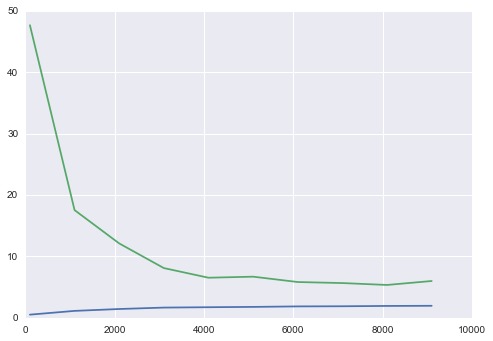

In [12]:
%%time 
#how long do these trainings take? Ask Jupyter using magic. I think it's actually called magic...
features=['Month','Day','Hour'];
trainSize, trainError, CVError=FeatureChoice(features, 10000, 1000, 1000,10,10)
#We can plot what we did below
plt.plot(trainSize,trainError,trainSize,CVError)

In [ ]:
#The above plot show error on the Y-axis (lower is better) and num of examples in training set on the X-axis.
#Error for the training set is in blue
#Error for CV set is in green
#As we would like to see, as number of training examples increases, error in training set goes up
#(less overfitting) and error in CV set goes down.
#Where they are converging is about where the error for the test set will be found.
#However, the CV error is still relatively high. Perhaps using more features will help?

Wall time: 6.33 s


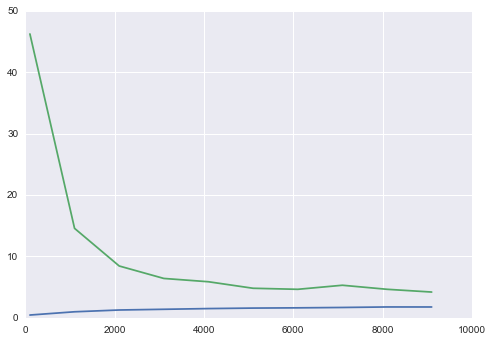

In [13]:
%%time
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
trainSize, trainError, CVError=FeatureChoice(features, 10000, 1000, 1000,10,10)
plt.plot(trainSize,trainError,trainSize,CVError)
#Here we have a bit better final error for the CV set, but what if we manipulate number of trees or tree depth?

Wall time: 8.54 s


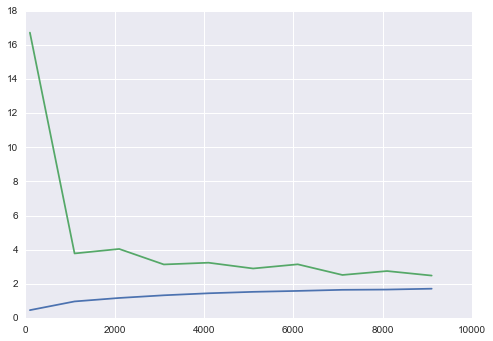

In [14]:
%%time
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
trainSize, trainError, CVError=FeatureChoice(features, 10000, 1000, 1000,100,10)
plt.plot(trainSize,trainError,trainSize,CVError)
#And with different numbers of trees (100 instead of 10)
#More trees are better, but computationally more taxing.

Wall time: 6.47 s


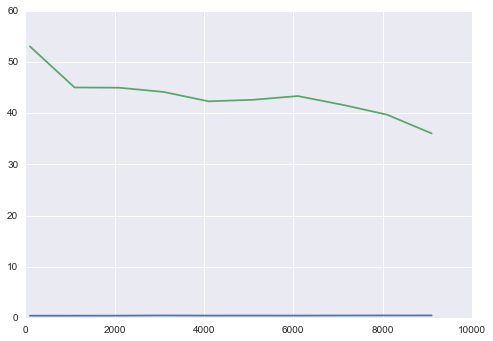

In [15]:
%%time
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
trainSize, trainError, CVError=FeatureChoice(features, 10000, 1000, 1000,10,20)
plt.plot(trainSize,trainError,trainSize,CVError)
#If instead we keep tree size at 10 but increase the max depth each tree can grow to 20:

In [ ]:
#Above I set the max_depth of the trees to 20, and am getting overfitting.
#The training error stays at 0 while the CV error stays quite large.
#We need to change things to get the lines to converge faster.

Wall time: 35.8 s


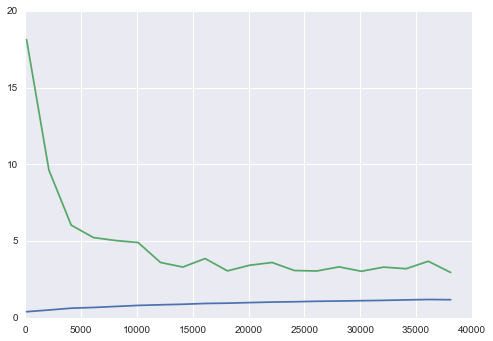

In [48]:
%%time
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
trainSize, trainError, CVError=FeatureChoice(features, 40000, 2000, 1000,100,15)
plt.plot(trainSize,trainError,trainSize,CVError)

In [ ]:
#More trees help to keep it the overfitting down, but is more computationally intensive.

Wall time: 17.5 s


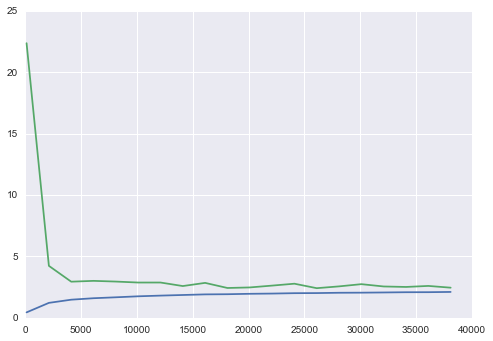

In [51]:
%%time
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
trainSize, trainError, CVError=FeatureChoice(features, 40000, 2000, 1000,50,10)
plt.plot(trainSize,trainError,trainSize,CVError)

Wall time: 23.7 s


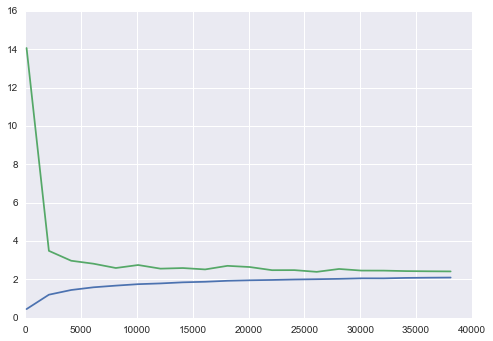

In [52]:
%%time
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
trainSize, trainError, CVError=FeatureChoice(features, 40000, 2000, 1000,100,10)
plt.plot(trainSize,trainError,trainSize,CVError)

Wall time: 1min 20s


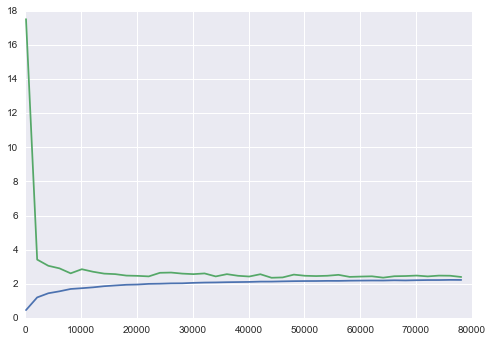

In [58]:
%%time
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
trainSize, trainError, CVError=FeatureChoice(features, 80000, 2000, 1000,100,10)
plt.plot(trainSize,trainError,trainSize,CVError)

In [59]:
CVError[-1]

2.3939434715962307

In [ ]:
#Now, I need to start working with the full set.

In [16]:
n=len(Train);
nTrain=int(n*.8)
nCV=n-nTrain
subTrain1=Train.sample(n)
trainingset=subTrain1[0:nTrain]
CVset=subTrain1[nTrain:]

In [18]:
%%time
#Let's see how big of a set we can train on:
features=['Minute','Y_binned','Address2_2','Address3_2','X_binned','Hour','Year']
nT=len(trainingset);
nCV=len(CVset);

train_data=trainingset[['Outcome']+features].sample(nT).values
forest=RandomForestClassifier(n_estimators=15,n_jobs=-1, max_depth=10)
forest=forest.fit(train_data[0::,1::],list(train_data[0::,0]))
output=forest.predict_proba(train_data[0::,1::])

outcomesused=sorted(pd.value_counts(train_data[:,0]).index.values)
elmToAdd=[];
for elm in list(range(0,len(Train['Outcome'].unique()))):
    if elm not in outcomesused:
        elmToAdd.append(elm)
output2=output
for elm in elmToAdd: #Insert 0 columns in for the missed outcomes
    output2=np.insert(output2, [elm], [0],axis=1)

colNum=len(Train['Outcome'].unique())
row  = np.array(list(range(0, nT)))
col  = np.array(train_data[0:nT,0].astype(int))
data = np.array(list(np.ones(nT)))
test=sparse.coo_matrix((data,(row,col)), shape=(nT,colNum)).todense()

logPredict=np.log(output2[0:nT]);
#getting rid of the -inf and making them zero:
logPredict[logPredict == -np.inf] = -100
#picking out and summing the percent of correct choice:
errorTrain=np.sum(-np.multiply(logPredict,test))/nT
print(errorTrain)

CV_data=CVset[['Outcome']+features].sample(nCV).values
CVoutput=forest.predict_proba(CV_data[0::,1::])

output2=CVoutput
for elm in elmToAdd:
    output2=np.insert(output2, [elm], [0],axis=1)

colNum=len(Train['Outcome'].unique())
row  = np.array(list(range(0, nCV)))
col  = np.array(CV_data[0:nCV,0].astype(int))
data = np.array(list(np.ones(nCV)))
test=sparse.coo_matrix((data,(row,col)), shape=(nCV,colNum)).todense()

logPredict=np.log(output2[0:nCV]);
logPredict[logPredict == -np.inf] = -100
errorCV=np.sum(-np.multiply(logPredict,test))/nCV
print(errorCV)

2.37553234169
2.42482117443
Wall time: 19.7 s


In [ ]:
#Number of trees was chosen based on amount of memory in computer.
#If I find a way to batch my data, I will up number of trees.

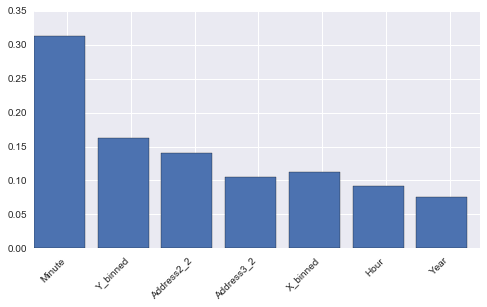

In [19]:
#And, we can see how important each feature is to the learning algorithm. 
horizontal=[]
for x in range(0,len(features)):
    horizontal.append(x);
importance=forest.feature_importances_;
plt.figure(1)
h = plt.bar(horizontal, importance, label=features);
plt.subplots_adjust(bottom=0.3);
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h];
plt.xticks(xticks_pos, features,  ha='right', rotation=45);

In [20]:
#Now it's time to use the forest on the test set:
#This set has also been cleaned previously. 
Test=pd.read_csv('TestNum.csv', header=0)

In [21]:
Test.head()

,Id,Weekday,Address3_2,Address2_2,Year,Month,Day,Hour,Minute,X_binned,Y_binned
0,0,6,100,16,2015,5,10,23,59,7,3.0
1,1,6,100,100,2015,5,10,23,51,7,3.0
2,2,6,100,16,2015,5,10,23,50,6,8.0
3,3,6,0,100,2015,5,10,23,45,5,2.0
4,4,6,0,100,2015,5,10,23,45,5,2.0


In [22]:
%%time
features=['Month','Day','Hour','Minute','Year','Address3_2','Address2_2']
nTest=len(Test);
Test_data=Test[features].values
Testoutput=forest.predict_proba(Test_data[0::,0::])

Wall time: 10.4 s


In [23]:
#But, the outcomes are currently just numbers, need to realign with categories.
#These were taken from the cleaning notebook that made the files numbers.
CategoriesForTest=['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT',
       'DRUG/NARCOTIC', 'VEHICLE THEFT', 'VANDALISM', 'WARRANTS',
       'BURGLARY', 'SUSPICIOUS OCC', 'MISSING PERSON', 'ROBBERY', 'FRAUD',
       'FORGERY/COUNTERFEITING', 'SECONDARY CODES', 'WEAPON LAWS',
       'PROSTITUTION', 'TRESPASS', 'STOLEN PROPERTY',
       'SEX OFFENSES FORCIBLE', 'DISORDERLY CONDUCT', 'DRUNKENNESS',
       'RECOVERED VEHICLE', 'KIDNAPPING', 'DRIVING UNDER THE INFLUENCE',
       'RUNAWAY', 'LIQUOR LAWS', 'ARSON', 'LOITERING', 'EMBEZZLEMENT',
       'SUICIDE', 'FAMILY OFFENSES', 'BAD CHECKS', 'BRIBERY', 'EXTORTION',
       'SEX OFFENSES NON FORCIBLE', 'GAMBLING', 'PORNOGRAPHY/OBSCENE MAT',
       'TREA'];

In [24]:
#Now make into new panda dataframe for easier manipulation and output
TestForestPanda = pd.DataFrame(Testoutput,columns=CategoriesForTest)

In [25]:
TestForestPanda.head()

,LARCENY/THEFT,OTHER OFFENSES,NON-CRIMINAL,ASSAULT,DRUG/NARCOTIC,VEHICLE THEFT,VANDALISM,WARRANTS,BURGLARY,SUSPICIOUS OCC,...,EMBEZZLEMENT,SUICIDE,FAMILY OFFENSES,BAD CHECKS,BRIBERY,EXTORTION,SEX OFFENSES NON FORCIBLE,GAMBLING,PORNOGRAPHY/OBSCENE MAT,TREA
0,0.306812,0.198553,0.046178,0.059922,0.048344,0.103340,0.026305,0.055276,0.018982,0.017351,...,0.000013,0.000337,0.000000,0.000025,0.0,0.000000,0.000000,0.000256,0.0,0.0
1,0.306812,0.198553,0.046178,0.059922,0.048344,0.103340,0.026305,0.055276,0.018982,0.017351,...,0.000013,0.000337,0.000000,0.000025,0.0,0.000000,0.000000,0.000256,0.0,0.0
2,0.306812,0.198553,0.046178,0.059922,0.048344,0.103340,0.026305,0.055276,0.018982,0.017351,...,0.000013,0.000337,0.000000,0.000025,0.0,0.000000,0.000000,0.000256,0.0,0.0
3,0.121906,0.231891,0.105822,0.057315,0.040580,0.141538,0.028817,0.055716,0.005534,0.081572,...,0.000285,0.000026,0.000018,0.000129,0.0,0.000092,0.000037,0.000149,0.0,0.0
4,0.121906,0.231891,0.105822,0.057315,0.040580,0.141538,0.028817,0.055716,0.005534,0.081572,...,0.000285,0.000026,0.000018,0.000129,0.0,0.000092,0.000037,0.000149,0.0,0.0


In [26]:
#Reorder columns alphabetically to match order Kaggle's desired order
TestForestPanda.sort(columns=None, axis=1, ascending=True, inplace=True)

C:\Users\KLK\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


In [27]:
#Attach the id's
TestForestPanda.insert(0, 'Id', Test['Id'].values, allow_duplicates=False)

In [28]:
TestForestPanda.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.000479,0.059922,0.000025,0.0,0.018982,0.021370,0.002855,0.048344,0.007522,...,0.000000,0.010522,0.000337,0.017351,0.0,0.009837,0.026305,0.103340,0.055276,0.007919
1,1,0.000479,0.059922,0.000025,0.0,0.018982,0.021370,0.002855,0.048344,0.007522,...,0.000000,0.010522,0.000337,0.017351,0.0,0.009837,0.026305,0.103340,0.055276,0.007919
2,2,0.000479,0.059922,0.000025,0.0,0.018982,0.021370,0.002855,0.048344,0.007522,...,0.000000,0.010522,0.000337,0.017351,0.0,0.009837,0.026305,0.103340,0.055276,0.007919
3,3,0.000107,0.057315,0.000129,0.0,0.005534,0.023996,0.007323,0.040580,0.009041,...,0.000037,0.010924,0.000026,0.081572,0.0,0.002607,0.028817,0.141538,0.055716,0.008279
4,4,0.000107,0.057315,0.000129,0.0,0.005534,0.023996,0.007323,0.040580,0.009041,...,0.000037,0.010924,0.000026,0.081572,0.0,0.002607,0.028817,0.141538,0.055716,0.008279


In [29]:
#And (finally!) write to csv:
TestForestPanda.to_csv('TestForest.csv',header=True, index=False)

In [ ]:
#What kind of results am I getting? Well, for...
#features=['Month','Day','Hour','Minute','Year','Address3_2','Address2_2']
#Estimators=10, max_Depth=10
# TrainError=2.43, CVError=2.48, TestError(Kaggle)=2.47